**EXP3 Predicitng Missing Cell-Types from Bulks using BayesPrism Residual**

*This file includes EXP2 specifics (outlined below), as well as the data preprocessing, QC, and creates the pseudobulks used in other experiments.*

Code based on:
1. https://github.com/greenelab/sc_bulk_ood/blob/main/sc_preprocessing/0_qc_notebooks/scanpy_analysis_pbmc6k.ipynb
2. https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html

Data downloaded from: https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE176171
Original paper: https://pubmed.ncbi.nlm.nih.gov/35296864/ PMID: 35296864
Source name	omental adipose tissue
Organism	Homo sapiens
Characteristics	tissue: white adipose tissue
Sex: female
age: 29y
bmi: 49.3
surgery: VSG

Experimental Details: https://docs.google.com/spreadsheets/d/1fMV_URm95iPh-6rew-Be27I1-i8PNgGNWi2D_UO2V9w/edit#gid=0

Summary: Preprocessed data used to create multiple pseudobulk files in previous notebooks. Here we import those random-proportion bulks and prepare files to be run in EXP2_bayesprism_pbmc.R.

*This file can be run one kernel at a time, or all at once*

In [1]:
# import the dependencies
import sys
sys.path.insert(1, '../../')
sys.path.insert(1, '../')
sys.path.insert(1, '../../../../../')

from functions import sn_sc_preprocess
from functions import validation_processing as vp
from importlib import reload
reload(sn_sc_preprocess)
reload(vp)
# general imports
import warnings
import numpy as np
from numpy import random
import pandas as pd
import scanpy as sc
from anndata import AnnData as ad
from tabulate import tabulate

import celltypist
from celltypist import models

import tensorflow as tf
from tensorflow.keras.utils import to_categorical

import scipy as sp
from scipy.stats import spearmanr, pearsonr
from scipy.sparse import coo_matrix
from scipy.sparse import csr_matrix
import scipy.stats as stats
from scipy.spatial.distance import euclidean
from collections import Counter
import scipy as sp
from scipy.optimize import nnls
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage, dendrogram


# Images, plots, display, and visualization
import matplotlib.pyplot as plt
from matplotlib.pyplot import rc_context
import seaborn as sns
import umap
from sklearn.utils import resample
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

# programming stuff
import time
import os, sys
import pickle
from pathlib import Path

In [2]:
#####################
### set the study ###
#####################
#results paths:
res_name = "MCT_adp_EXP3"
pseudos_name = "MCT_adp_EXP3"
path = f"/../data/"
aug_data_path = "/../data/EXP3/"
data_path = "/../data/EXP3/BayesPrism/"
#noise_type 
nt = "nonoise"
bulk_type = "realistic"
random_seed = 88
bulks_type = f"{bulk_type}prop_{nt}"

## **Reading and QCing the data:**

In [3]:
actual_path = os.getcwd()
path = f"{actual_path}{path}"
aug_data_path = f"{actual_path}{aug_data_path}"
data_path = f"{actual_path}{data_path}"

In [4]:
#single cell, missing 2 cell types
sc_adata_path = os.path.join(aug_data_path, f"{pseudos_name}_scadata_notlog.h5ad")
print(sc_adata_path)
sc_adata_path = Path(sc_adata_path)
sc_adata = sc.read_h5ad(sc_adata_path)
sc_adata

/Users/ivicha/Documents/Project_missingcelltype/pred_missing_celltypes/preprocessing/../data/EXP3/MCT_adp_EXP3_scadata_notlog.h5ad


AnnData object with n_obs × n_vars = 18490 × 26672
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'cell_types'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_var_genes'

In [5]:
#single nucleus, missing 0 cell types
sn_adata_path = os.path.join(aug_data_path, f"{pseudos_name}_snadata_notlog.h5ad")
print(sn_adata_path)
sn_adata_path = Path(sn_adata_path)
sn_adata = sc.read_h5ad(sn_adata_path)
sn_adata

/Users/ivicha/Documents/Project_missingcelltype/pred_missing_celltypes/preprocessing/../data/EXP3/MCT_adp_EXP3_snadata_notlog.h5ad


AnnData object with n_obs × n_vars = 113017 × 28242
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'cell_types'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_var_genes'

QC imported dataset:

In [6]:
#QC that it is not normalized
sc_adata.X.max()

1558.0

         Falling back to preprocessing with `sc.pp.pca` and default params.


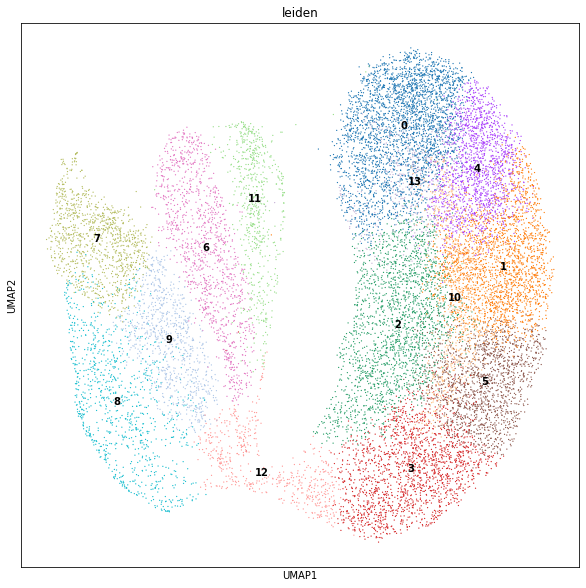

In [7]:
# lets use Leiden clustering
sc.pp.neighbors(sc_adata)
sc.tl.umap(sc_adata)
sc.tl.leiden(sc_adata, resolution=0.8)
with rc_context({'figure.figsize': (10, 10)}):
    sc.pl.umap(sc_adata, color='leiden', legend_loc='on data')

In [8]:
Counter(sc_adata.obs["cell_types"])

Counter({'dendritic cell': 983,
         'monocyte': 636,
         'preadipocyte': 13461,
         'endothelial cell of lymphatic vessel': 157,
         'macrophage': 1410,
         'T cell': 807,
         'endothelial cell': 542,
         'immature NK T cell': 389,
         'pericyte cell': 52,
         'mast cell': 53})

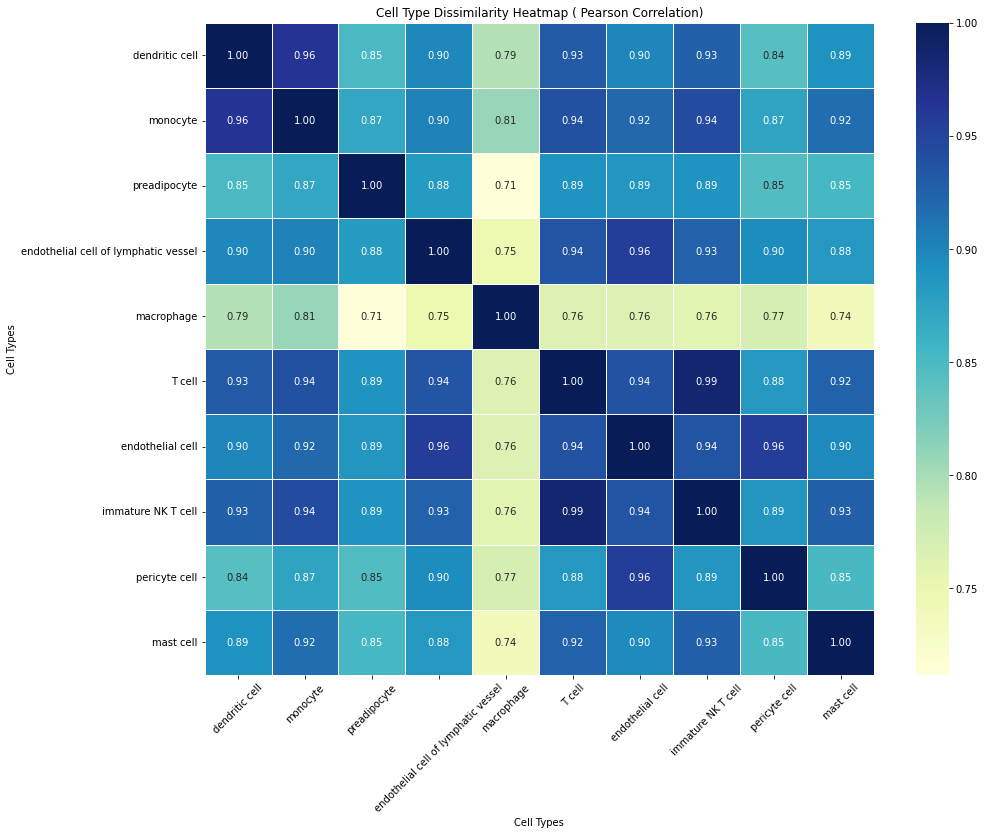

In [9]:
# Define the number of samples for resampling
num_samples = 10000

# Making cell type reference without scaling
cell_types = sc_adata.obs["cell_types"].unique()
gene_ids = sc_adata.var["gene_ids"]
ref_raw = pd.DataFrame(index=gene_ids, columns=cell_types)

for cell_type in cell_types:
    cell_df = sc_adata[sc_adata.obs["cell_types"].isin([cell_type])]
    cell_sample = resample(cell_df, n_samples=num_samples, replace=True)
    x = cell_sample.X.sum(axis=0)
    sum_over_genes = pd.DataFrame(x).T
    ref_raw[cell_type] = sum_over_genes.values

# Calculate Pearson correlations
correlation_matrix = ref_raw.corr()

# Create a DataFrame for the similarity matrix
cell_types_similarity =correlation_matrix  # Convert correlations to dissimilarities
similarity_df = pd.DataFrame(cell_types_similarity, columns=cell_types, index=cell_types)

# Create a heatmap to visualize the similarities
plt.figure(figsize=(15, 12))
sns.heatmap(similarity_df, cmap="YlGnBu", annot=True, fmt=".2f", linewidths=0.5)
plt.title("Cell Type Dissimilarity Heatmap ( Pearson Correlation)")
plt.xlabel("Cell Types")
plt.ylabel("Cell Types")
plt.xticks(rotation=45)
plt.show()

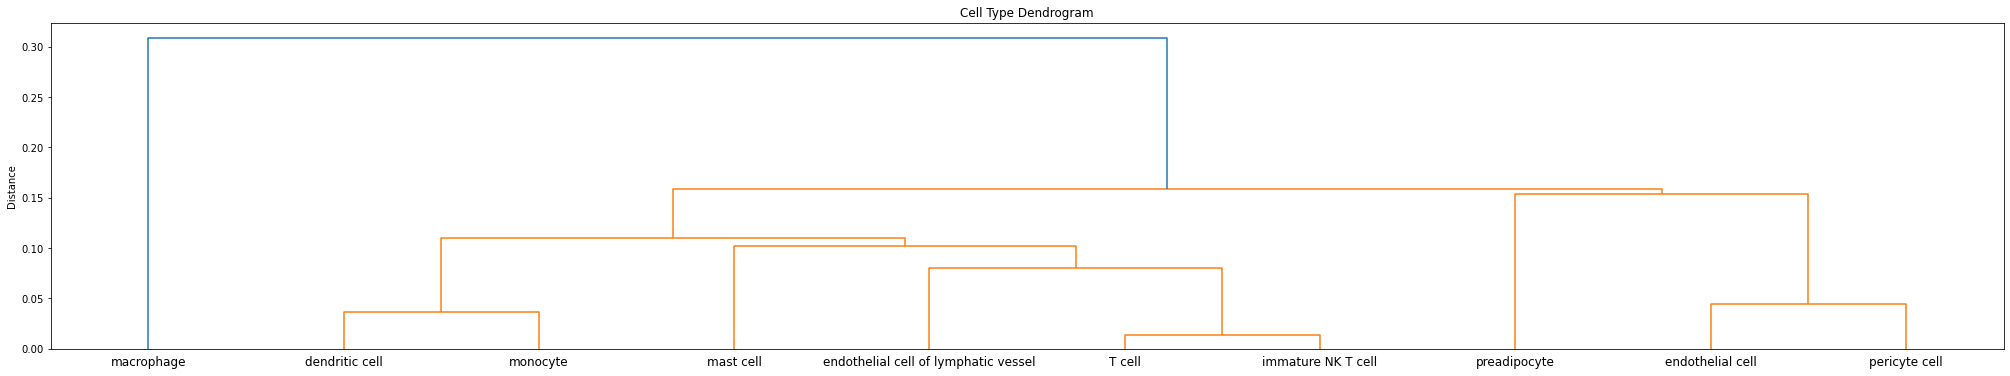

In [10]:
# Calculate Pearson correlations
correlation_matrix = ref_raw.corr()

# Create a DataFrame for the similarity matrix
cell_types_similarity =1 - correlation_matrix  # Convert correlations to dissimilarities
similarity_df = pd.DataFrame(cell_types_similarity, columns=cell_types, index=cell_types)

# Create a dendrogram to visualize hierarchical clustering
linkage_matrix = linkage(squareform(cell_types_similarity), method='ward')
plt.figure(figsize=(35, 6))
dendrogram(linkage_matrix, labels=cell_types, orientation='top')
plt.title("Cell Type Dendrogram")
plt.ylabel("Distance")
plt.show()

In [11]:
sc_adata.obs["scpred_CellType"] = sc_adata.obs["cell_types"]

Cell Types are already missing from reference, so importing Pseudobulks

## **Importing and QCing Pseudobulks**

In [12]:
#using SN because that's the data from which the pseudobulks were created
num_cell_type_specific = 50 * int(sn_adata.obs["cell_types"].unique().shape[0])
num_bulks = 200+num_cell_type_specific+200+200
num_bulks

1200

In [13]:
X_full, Y_full, gene_df, meta_df= sn_sc_preprocess.read_all_pseudobulk_files(data_path=aug_data_path, noise_type=f"{nt}_", file_name = pseudos_name, num_bulks_training = num_bulks, num_files=10, random_selection = False)
X_full.index = meta_df.index
Y_full.index = meta_df.index

0
1
2
3
4
5
6
7
8
9


(8000, 2)
(8000, 2)


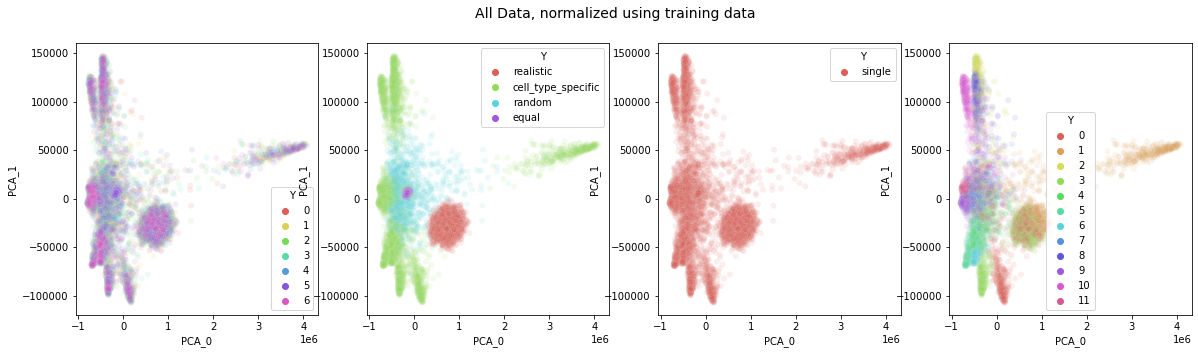

In [14]:
## plot samples (some of them for speed)
X_temp = X_full.iloc[0:8000]
Y_temp_p = Y_full.iloc[0:8000]
meta_temp = meta_df.iloc[0:8000]

plot_df = vp.get_pca_for_plotting(X_temp)

fig, axs = plt.subplots(1, 4, figsize=(20,5))

Y_temp = np.copy(Y_temp_p)
Y_temp = np.argmax(Y_temp, axis=1) 

vp.plot_pca(plot_df, meta_temp.sample_id.to_numpy(), axs[0], title=f"")
vp.plot_pca(plot_df, meta_temp.cell_prop_type.to_numpy(), axs[1], title=f"")
vp.plot_pca(plot_df, meta_temp.samp_type.to_numpy(), axs[2], title=f"")
vp.plot_pca(plot_df, Y_temp, axs[3], title=f"")

fig.suptitle("All Data, normalized using training data", fontsize=14)

fig.show()

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 8000 samples in 0.109s...
[t-SNE] Computed neighbors for 8000 samples in 19.136s...
[t-SNE] Computed conditional probabilities for sample 1000 / 8000
[t-SNE] Computed conditional probabilities for sample 2000 / 8000
[t-SNE] Computed conditional probabilities for sample 3000 / 8000
[t-SNE] Computed conditional probabilities for sample 4000 / 8000
[t-SNE] Computed conditional probabilities for sample 5000 / 8000
[t-SNE] Computed conditional probabilities for sample 6000 / 8000
[t-SNE] Computed conditional probabilities for sample 7000 / 8000
[t-SNE] Computed conditional probabilities for sample 8000 / 8000
[t-SNE] Mean sigma: 6152.857734
[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.788010
[t-SNE] KL divergence after 500 iterations: 0.976001
(8000, 2)
(8000, 2)


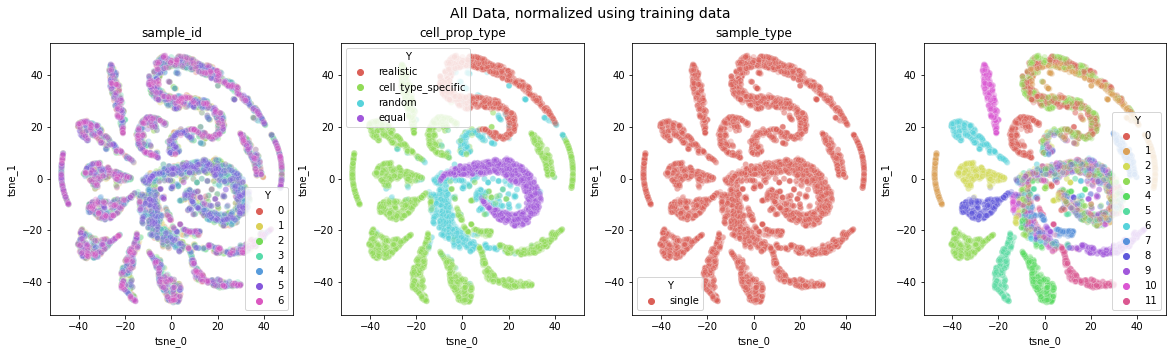

In [15]:
## plot samples (some of them for speed)
X_temp = X_full.iloc[0:8000]
Y_temp_p = Y_full.iloc[0:8000]
meta_temp = meta_df.iloc[0:8000]

plot_df = vp.get_tsne_for_plotting(X_temp)

fig, axs = plt.subplots(1, 4, figsize=(20,5))

Y_temp = np.copy(Y_temp_p)
Y_temp = np.argmax(Y_temp, axis=1) 

vp.plot_tsne(plot_df, meta_temp.sample_id.to_numpy(), axs[0], title=f"sample_id")
vp.plot_tsne(plot_df, meta_temp.cell_prop_type.to_numpy(), axs[1], title=f"cell_prop_type")
vp.plot_tsne(plot_df, meta_temp.samp_type.to_numpy(), axs[2], title=f"sample_type")
vp.plot_tsne(plot_df, Y_temp, axs[3], title=f"")

fig.suptitle("All Data, normalized using training data", fontsize=14)
fig.show()

In [16]:
#cut to only the random samples
idx_interest = np.where(meta_df.cell_prop_type == bulk_type)[0]
pseudos_df = X_full.iloc[idx_interest]
prop_df = Y_full.iloc[idx_interest]
pseudos_df.index = range(0,len(pseudos_df))
prop_df.index = pseudos_df.index
meta_df.index = meta_df.index
pseudos_df

gene_ids,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2ML1-AS1,A3GALT2,A4GALT,A4GNT,...,AP003550.1,AC005544.2,AC025674.2,AC105924.1,AC239803.3,AL049555.1,AL109945.1,HIST1H3G,PAEP,PLA2G1B
0,55.0,130.0,10.0,2150.0,90.0,43.0,767.0,17.0,185.0,8.0,...,0.0,3.0,0.0,3.0,0.0,1.0,0.0,0.0,4.0,0.0
1,45.0,107.0,25.0,1857.0,94.0,58.0,783.0,19.0,232.0,6.0,...,0.0,0.0,0.0,3.0,1.0,1.0,0.0,0.0,2.0,0.0
2,54.0,117.0,22.0,2155.0,94.0,58.0,814.0,11.0,209.0,10.0,...,0.0,0.0,0.0,2.0,5.0,4.0,0.0,0.0,1.0,0.0
3,47.0,103.0,18.0,3238.0,98.0,37.0,797.0,11.0,295.0,8.0,...,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,3.0,0.0
4,45.0,120.0,16.0,2547.0,107.0,48.0,788.0,12.0,200.0,7.0,...,0.0,3.0,1.0,0.0,0.0,0.0,1.0,2.0,2.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,52.0,101.0,11.0,2958.0,140.0,51.0,749.0,10.0,215.0,6.0,...,1.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,1.0,1.0
1996,51.0,126.0,13.0,3043.0,117.0,48.0,737.0,19.0,229.0,5.0,...,0.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,2.0,0.0
1997,69.0,120.0,11.0,2953.0,119.0,54.0,636.0,14.0,206.0,3.0,...,0.0,0.0,0.0,2.0,0.0,1.0,0.0,2.0,6.0,0.0
1998,52.0,118.0,12.0,2606.0,107.0,53.0,753.0,19.0,181.0,5.0,...,1.0,0.0,0.0,2.0,1.0,1.0,0.0,1.0,4.0,1.0


In [17]:
#cutting to 1000 pseudos w/ random seed
random.seed(seed=random_seed)
idx_to_keep = np.random.choice(pseudos_df.index, 1000, replace=False)
#cutting both props and pseudos
pseudos_df = pseudos_df.iloc[idx_to_keep]
prop_df = prop_df.iloc[idx_to_keep]
pseudos_df

gene_ids,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2ML1-AS1,A3GALT2,A4GALT,A4GNT,...,AP003550.1,AC005544.2,AC025674.2,AC105924.1,AC239803.3,AL049555.1,AL109945.1,HIST1H3G,PAEP,PLA2G1B
1059,54.0,129.0,16.0,2119.0,122.0,37.0,696.0,15.0,156.0,6.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,2.0,0.0
929,56.0,128.0,16.0,2985.0,139.0,56.0,679.0,15.0,249.0,6.0,...,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0
1506,56.0,115.0,13.0,2966.0,94.0,53.0,747.0,12.0,260.0,8.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
237,44.0,100.0,18.0,3364.0,114.0,66.0,806.0,16.0,222.0,9.0,...,0.0,0.0,0.0,1.0,2.0,1.0,0.0,1.0,3.0,0.0
1371,59.0,127.0,13.0,2712.0,93.0,46.0,699.0,10.0,220.0,11.0,...,0.0,1.0,0.0,3.0,1.0,3.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1573,57.0,120.0,16.0,2365.0,85.0,54.0,720.0,12.0,259.0,6.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,2.0,0.0
1132,69.0,128.0,21.0,2261.0,66.0,54.0,748.0,19.0,216.0,5.0,...,0.0,0.0,0.0,3.0,0.0,1.0,1.0,1.0,1.0,0.0
1998,52.0,118.0,12.0,2606.0,107.0,53.0,753.0,19.0,181.0,5.0,...,1.0,0.0,0.0,2.0,1.0,1.0,0.0,1.0,4.0,1.0
1988,42.0,112.0,9.0,2961.0,118.0,65.0,702.0,15.0,209.0,5.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


Putting together all reference expression and proportions.

Limiting Cell Type number for computation:

In [18]:
num = 2

In [19]:
cell_order = prop_df.columns

In [20]:
#import anndata object
adata_path = os.path.join(aug_data_path, f"{pseudos_name}_scadata_notlog.h5ad")
adata_path = Path(adata_path)
adata = sc.read_h5ad(adata_path)

cell_types_to_limit = cell_order
#define the cell types to limit and the desired maximum number of cells
max_cells_per_type = 1000

#dreate a mask to identify cells from the cell types to limit
mask_to_limit = adata.obs["cell_types"].isin(cell_types_to_limit)

#create a mask for the remaining cell types
mask_remaining = ~mask_to_limit

#initialize a dictionary to keep track of removed cells per cell type
removed_cells_count = {cell_type: 0 for cell_type in cell_types_to_limit}

#initialize arrays to store new observations and filtered indices
new_obs = []
filtered_indices = []

#iterate through each cell in the original sn_adata object
for cell_idx, cell_type in enumerate(adata.obs["cell_types"]):
    if cell_type in cell_types_to_limit:
        removed_count = removed_cells_count.get(cell_type, 0)
        if removed_count < max_cells_per_type:
            removed_cells_count[cell_type] = removed_count + 1
            filtered_indices.append(cell_idx)

#create a new AnnData object with the filtered cells
filtered_sc_adata = sc.AnnData(
    X=adata.X[filtered_indices],
    obs=adata.obs.iloc[filtered_indices],
    var=adata.var
)

#cppend the remaining cell types to the filtered sn_adata object
filtered_sc_adata = filtered_sc_adata.concatenate(
    adata[mask_remaining],
    join="outer"
)
#QC
print(Counter(filtered_sc_adata.obs.cell_types))
#save as anndata object
adata_path = os.path.join(aug_data_path, f"{pseudos_name}_scadata_limitedcells_notlog.h5ad")
adata_path = Path(adata_path)
filtered_sc_adata.write_h5ad(adata_path)

... storing 'cell_types' as categorical


Counter({'preadipocyte': 1000, 'macrophage': 1000, 'dendritic cell': 983, 'T cell': 807, 'monocyte': 636, 'endothelial cell': 542, 'immature NK T cell': 389, 'endothelial cell of lymphatic vessel': 157, 'mast cell': 53, 'pericyte cell': 52})


In [21]:
# initializing dicitonaries of proportions and cell references.
all_refs = dict()
all_prop_refs_rebalanced = dict()
all_prop_refs = dict()

In [22]:
#with no cell missing is just the anndata object as is
#import anndata object
adata_path = os.path.join(aug_data_path, f"{pseudos_name}_scadata_limitedcells_notlog.h5ad")
adata_path = Path(adata_path)
sc_adata = sc.read_h5ad(adata_path)
#all cell types included QC
print(Counter(sc_adata.obs.cell_types))
#to dense matrix and saving into path
dense_matrix = sc_adata.X.todense()
sc_profile_file = os.path.join(aug_data_path, f"{res_name}_{num}missing_sig.csv")
sc_profile_path = Path(sc_profile_file)
dense_df = pd.DataFrame(dense_matrix, columns = sc_adata.var['gene_ids'])
dense_df.insert(loc=0, column='cell_types', value=sc_adata.obs["cell_types"].to_list())
#save file
dense_df.index = dense_df.index +  1
#qc
sig_df_sn = dense_df
print(sig_df_sn.shape)
all_refs[num] = sig_df_sn

Counter({'preadipocyte': 1000, 'macrophage': 1000, 'dendritic cell': 983, 'T cell': 807, 'monocyte': 636, 'endothelial cell': 542, 'immature NK T cell': 389, 'endothelial cell of lymphatic vessel': 157, 'mast cell': 53, 'pericyte cell': 52})
(5619, 26673)


In [23]:
sn_cell_types = vp.make_prop_table(sn_adata, "cell_types")
sn_cell_types = sn_cell_types.drop(axis=0, index = len(sn_cell_types)-1)
sn_cell_types = sn_cell_types.sort_values('Cell_Types')
sn_cell_types = sn_cell_types.reindex()
sn_cell_types

,Cell_Types,Num_Cells,Prop_Cells
7,T cell,3022,0.026739
8,dendritic cell,679,0.006008
4,endothelial cell,11480,0.101578
5,endothelial cell of lymphatic vessel,2339,0.020696
1,fat cell,24825,0.219657
11,immature NK T cell,1073,0.009494
2,macrophage,13625,0.120557
9,mast cell,883,0.007813
0,mesothelial cell,26276,0.232496
10,monocyte,709,0.006273


In [24]:
sc_cell_types = vp.make_prop_table(sc_adata, "cell_types")
sc_cell_types = sc_cell_types.drop(axis=0, index = len(sc_cell_types)-1)
sc_cell_types = sc_cell_types.sort_values('Cell_Types')
sc_cell_types = sc_cell_types.reindex()
sc_cell_types

,Cell_Types,Num_Cells,Prop_Cells
5,T cell,807,0.143620
0,dendritic cell,983,0.174942
6,endothelial cell,542,0.096458
3,endothelial cell of lymphatic vessel,157,0.027941
7,immature NK T cell,389,0.069229
4,macrophage,1000,0.177968
9,mast cell,53,0.009432
1,monocyte,636,0.113187
8,pericyte cell,52,0.009254
2,preadipocyte,1000,0.177968


In [25]:
cells_to_miss = np.setdiff1d(sn_cell_types["Cell_Types"], sc_cell_types["Cell_Types"])
cells_to_miss

array(['fat cell', 'mesothelial cell'], dtype=object)

In [26]:
#assigning the rest in a loop
num = len(cells_to_miss)
cell_order = prop_df.columns

In [27]:
prop_df

,mesothelial cell,fat cell,macrophage,preadipocyte,endothelial cell,endothelial cell of lymphatic vessel,pericyte cell,T cell,dendritic cell,mast cell,monocyte,immature NK T cell
1059,0.271111,0.242931,0.118521,0.239495,0.018192,0.020718,0.003957,0.014857,0.001838,0.032553,0.02018,0.015646
929,0.23038,0.177024,0.096562,0.279433,0.110179,0.020464,0.00785,0.004998,0.004378,0.05881,0.003665,0.006257
1506,0.286732,0.172803,0.061848,0.275625,0.154757,0.004968,0.00256,0.02239,0.00615,0.004275,0.000941,0.006951
237,0.151887,0.235572,0.166035,0.259285,0.115821,0.005894,0.015672,0.006133,0.008484,0.018908,0.01198,0.004328
1371,0.251828,0.171549,0.201263,0.264474,0.060236,0.004264,0.013875,0.019275,0.002364,0.006548,0.001162,0.003163
...,...,...,...,...,...,...,...,...,...,...,...,...
1573,0.252649,0.175555,0.10848,0.275674,0.057556,0.077842,0.005944,0.034932,0.004109,0.001269,0.001668,0.004321
1132,0.260152,0.221408,0.084049,0.286275,0.042746,0.015784,0.052034,0.025628,0.007834,0.001175,0.002365,0.00055
1998,0.276072,0.234815,0.106483,0.209433,0.081084,0.009403,0.0205,0.049767,0.001209,0.001988,0.007365,0.001881
1988,0.199085,0.232102,0.156469,0.260605,0.092223,0.010561,0.001909,0.025492,0.00092,0.008269,0.004246,0.008121


In [28]:
#assigning the rest 
num = len(cells_to_miss)
#dropping cell types missing from proportions
all_prop_refs_rebalanced[num] = prop_df.drop(cells_to_miss, axis=1) 
for idx,sample in all_prop_refs_rebalanced[num].iterrows():
    tot = np.sum(sample) #making them equal 1
    sample = sample / tot
all_prop_refs_rebalanced[2]    

,macrophage,preadipocyte,endothelial cell,endothelial cell of lymphatic vessel,pericyte cell,T cell,dendritic cell,mast cell,monocyte,immature NK T cell
1059,0.118521,0.239495,0.018192,0.020718,0.003957,0.014857,0.001838,0.032553,0.02018,0.015646
929,0.096562,0.279433,0.110179,0.020464,0.00785,0.004998,0.004378,0.05881,0.003665,0.006257
1506,0.061848,0.275625,0.154757,0.004968,0.00256,0.02239,0.00615,0.004275,0.000941,0.006951
237,0.166035,0.259285,0.115821,0.005894,0.015672,0.006133,0.008484,0.018908,0.01198,0.004328
1371,0.201263,0.264474,0.060236,0.004264,0.013875,0.019275,0.002364,0.006548,0.001162,0.003163
...,...,...,...,...,...,...,...,...,...,...
1573,0.10848,0.275674,0.057556,0.077842,0.005944,0.034932,0.004109,0.001269,0.001668,0.004321
1132,0.084049,0.286275,0.042746,0.015784,0.052034,0.025628,0.007834,0.001175,0.002365,0.00055
1998,0.106483,0.209433,0.081084,0.009403,0.0205,0.049767,0.001209,0.001988,0.007365,0.001881
1988,0.156469,0.260605,0.092223,0.010561,0.001909,0.025492,0.00092,0.008269,0.004246,0.008121


In [29]:
#allign indexes with R
all_prop_refs[num] = prop_df 
all_prop_refs[num].index = all_prop_refs[num].index + 1
all_prop_refs_rebalanced[num].index = all_prop_refs_rebalanced[num].index + 1
all_prop_refs[2]

,mesothelial cell,fat cell,macrophage,preadipocyte,endothelial cell,endothelial cell of lymphatic vessel,pericyte cell,T cell,dendritic cell,mast cell,monocyte,immature NK T cell
1060,0.271111,0.242931,0.118521,0.239495,0.018192,0.020718,0.003957,0.014857,0.001838,0.032553,0.02018,0.015646
930,0.23038,0.177024,0.096562,0.279433,0.110179,0.020464,0.00785,0.004998,0.004378,0.05881,0.003665,0.006257
1507,0.286732,0.172803,0.061848,0.275625,0.154757,0.004968,0.00256,0.02239,0.00615,0.004275,0.000941,0.006951
238,0.151887,0.235572,0.166035,0.259285,0.115821,0.005894,0.015672,0.006133,0.008484,0.018908,0.01198,0.004328
1372,0.251828,0.171549,0.201263,0.264474,0.060236,0.004264,0.013875,0.019275,0.002364,0.006548,0.001162,0.003163
...,...,...,...,...,...,...,...,...,...,...,...,...
1574,0.252649,0.175555,0.10848,0.275674,0.057556,0.077842,0.005944,0.034932,0.004109,0.001269,0.001668,0.004321
1133,0.260152,0.221408,0.084049,0.286275,0.042746,0.015784,0.052034,0.025628,0.007834,0.001175,0.002365,0.00055
1999,0.276072,0.234815,0.106483,0.209433,0.081084,0.009403,0.0205,0.049767,0.001209,0.001988,0.007365,0.001881
1989,0.199085,0.232102,0.156469,0.260605,0.092223,0.010561,0.001909,0.025492,0.00092,0.008269,0.004246,0.008121


In [30]:
#and save files
#rebalances proportions
sc_profile_file_ = os.path.join(aug_data_path, f"{res_name}_{num}missing_{bulks_type}_proprebal.csv")
sc_profile_path_ = Path(sc_profile_file_)
all_prop_refs_rebalanced[num].to_csv(sc_profile_path_, index=False)
#and not rebalances
sc_profile_file = os.path.join(aug_data_path, f"{res_name}_{num}missing_{bulks_type}_prop.csv")
sc_profile_path = Path(sc_profile_file)
all_prop_refs[num].to_csv(sc_profile_path, index=False)

Creating reference files

First from single-cell (missing 2):

In [31]:
#to dense matrix and copying into dict entry
dense_matrix = sc_adata.X.todense()
dense_mat = dict()    
cell_states = dict()
cols = ["cell_id", "cell_type", "cell_subtype", "tumor_state"] #for cell state
dense_mat[num] = dense_matrix.copy()

dense_df = pd.DataFrame(dense_mat[num], columns = sc_adata.var['gene_ids'].index)
dense_df.insert(loc=0, column='cell_types', value= sc_adata.obs["cell_types"].to_list())
dense_df

,cell_types,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2ML1-AS1,A3GALT2,A4GALT,...,ULBP1,WTH3DI,XIRP1,Z82196.2,Z84488.1,Z99755.2,Z99916.3,ZNF280A,ZPBP2,CD99.Y
0,dendritic cell,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,monocyte,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,preadipocyte,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,endothelial cell of lymphatic vessel,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,preadipocyte,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5614,dendritic cell,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5615,monocyte,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5616,mast cell,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5617,immature NK T cell,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [32]:
#matching proportion in reference (made from SC cells) to SN proportions
new_dense = pd.DataFrame(columns=dense_df.columns)
for cell_type in sn_cell_types["Cell_Types"]:
    idx_in_mat = sn_cell_types[sn_cell_types['Cell_Types'] == str(cell_type)].index[0]
    all_cells_from_type = dense_df[dense_df["cell_types"] == cell_type].index
    size = sn_cell_types['Num_Cells'].loc[idx_in_mat]
    if size > 1000:
        size = 1000
    if all_cells_from_type.shape != (0,):  
        if len(all_cells_from_type) < size:
            rep = True
        else:
            rep = False    
        random_idx = np.random.choice(all_cells_from_type, size=size, replace=rep)
        old_dense = dense_df.loc[random_idx]
        new_dense = pd.concat([new_dense, old_dense])
new_dense

,cell_types,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2ML1-AS1,A3GALT2,A4GALT,...,ULBP1,WTH3DI,XIRP1,Z82196.2,Z84488.1,Z99755.2,Z99916.3,ZNF280A,ZPBP2,CD99.Y
2658,T cell,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3146,T cell,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2917,T cell,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3816,T cell,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5412,T cell,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
363,preadipocyte,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
196,preadipocyte,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1383,preadipocyte,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1327,preadipocyte,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [33]:
dense_df = new_dense.sort_index()
dense_df

,cell_types,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2ML1-AS1,A3GALT2,A4GALT,...,ULBP1,WTH3DI,XIRP1,Z82196.2,Z84488.1,Z99755.2,Z99916.3,ZNF280A,ZPBP2,CD99.Y
0,dendritic cell,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,monocyte,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,monocyte,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,preadipocyte,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,endothelial cell of lymphatic vessel,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5616,mast cell,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5616,mast cell,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5616,mast cell,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5617,immature NK T cell,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [34]:
#does not have the cell types from SN
Counter(dense_df["cell_types"])

Counter({'dendritic cell': 679,
         'monocyte': 709,
         'preadipocyte': 1000,
         'endothelial cell of lymphatic vessel': 1000,
         'macrophage': 1000,
         'T cell': 1000,
         'endothelial cell': 1000,
         'immature NK T cell': 1000,
         'pericyte cell': 1000,
         'mast cell': 883})

In [35]:
#now creating the cell state file
# cell_id, cell_type, cell_subtype and tumor_state
cell_state = pd.DataFrame(columns = cols)
cell_state["cell_type"] = dense_df["cell_types"].to_list()
cell_state["cell_id"] = range(1,len(cell_state["cell_type"])+ 1 ) #+1 for R
cell_state["cell_subtype"] = dense_df["cell_types"].to_list()
cell_state["tumor_state"] = 0
#change idx to start at 1 for R
#save
num = 2
cell_states[num] = cell_state
cellstate_path = os.path.join(data_path, f"{res_name}_{bulks_type}_{num}missing_cellstate.csv")
cellstate_path = Path(cellstate_path)
cell_states[num].to_csv(cellstate_path, index = False)

#dropping cell types, they're now in cell state
dense_df.pop("cell_types")
#dense_df.to_csv(sc_profile_path, index=True)
all_refs[num] = dense_df
#qc
print(dense_df.shape)
print(cell_state.shape)

(9271, 26672)
(9271, 4)


In [36]:
mix = dict()
sig = dict()
num = 2
reference = all_refs[num]
reference.index = range(1, len(reference)+1)
#details
num_str = str(num)  
exp_id = str(res_name)
#and create files for EXP2 BP
mix[num], sig[num] = sn_sc_preprocess.write_bp_files(bp_path = data_path, out_file_id = res_name, 
                                        sig_df = reference,  X_train = pseudos_df, num_str = num_str, bulks_type= bulks_type)

Mixture (pseudobulks)

In [37]:
# mix[0] contains all pseudobulks
sc_profile_file = os.path.join(data_path, f"{exp_id}_{bulks_type}_mixture.csv")
sc_profile_path = Path(sc_profile_file)
mix[2].to_csv(sc_profile_path, index= True)
mix[2]

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
gene_ids,,,,,,,,,,,,,,,,,,,,,
A1BG,54.0,56.0,56.0,44.0,59.0,46.0,52.0,54.0,50.0,57.0,...,49.0,49.0,48.0,54.0,57.0,57.0,69.0,52.0,42.0,50.0
A1BG-AS1,129.0,128.0,115.0,100.0,127.0,117.0,116.0,117.0,118.0,121.0,...,84.0,124.0,116.0,104.0,112.0,120.0,128.0,118.0,112.0,133.0
A1CF,16.0,16.0,13.0,18.0,13.0,17.0,25.0,16.0,20.0,30.0,...,14.0,14.0,29.0,20.0,16.0,16.0,21.0,12.0,9.0,24.0
A2M,2119.0,2985.0,2966.0,3364.0,2712.0,2582.0,3109.0,3022.0,2749.0,1956.0,...,3057.0,2618.0,3193.0,2330.0,2887.0,2365.0,2261.0,2606.0,2961.0,2210.0
A2M-AS1,122.0,139.0,94.0,114.0,93.0,99.0,109.0,129.0,141.0,143.0,...,97.0,87.0,116.0,83.0,109.0,85.0,66.0,107.0,118.0,111.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AL049555.1,0.0,1.0,0.0,1.0,3.0,0.0,2.0,1.0,1.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
AL109945.1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
HIST1H3G,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,2.0,0.0,...,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0


And the reference from single-nucleus (0 missing):

In [38]:
num = 0

In [39]:
#import anndata object
adata_path = os.path.join(aug_data_path, f"{pseudos_name}_snadata_notlog.h5ad")
adata_path = Path(adata_path)
adata = sc.read_h5ad(adata_path)

cell_types_to_limit = cell_order
#define the cell types to limit and the desired maximum number of cells
max_cells_per_type = 1000

#dreate a mask to identify cells from the cell types to limit
mask_to_limit = adata.obs["cell_types"].isin(cell_types_to_limit)

#create a mask for the remaining cell types
mask_remaining = ~mask_to_limit

#initialize a dictionary to keep track of removed cells per cell type
removed_cells_count = {cell_type: 0 for cell_type in cell_types_to_limit}

#initialize arrays to store new observations and filtered indices
new_obs = []
filtered_indices = []

#iterate through each cell in the original sn_adata object
for cell_idx, cell_type in enumerate(adata.obs["cell_types"]):
    if cell_type in cell_types_to_limit:
        removed_count = removed_cells_count.get(cell_type, 0)
        if removed_count < max_cells_per_type:
            removed_cells_count[cell_type] = removed_count + 1
            filtered_indices.append(cell_idx)

#create a new AnnData object with the filtered cells
filtered_sn_adata = sc.AnnData(
    X=adata.X[filtered_indices],
    obs=adata.obs.iloc[filtered_indices],
    var=adata.var
)

#cppend the remaining cell types to the filtered sn_adata object
filtered_sn_adata = filtered_sn_adata.concatenate(
    adata[mask_remaining],
    join="outer"
)
#QC
print(Counter(filtered_sn_adata.obs.cell_types))
#save as anndata object
adata_path = os.path.join(aug_data_path, f"{pseudos_name}_snadata_limitedcells_notlog.h5ad")
adata_path = Path(adata_path)
filtered_sn_adata.write_h5ad(adata_path)

... storing 'cell_types' as categorical


Counter({'mesothelial cell': 1000, 'fat cell': 1000, 'macrophage': 1000, 'preadipocyte': 1000, 'endothelial cell': 1000, 'endothelial cell of lymphatic vessel': 1000, 'pericyte cell': 1000, 'T cell': 1000, 'immature NK T cell': 1000, 'mast cell': 883, 'monocyte': 709, 'dendritic cell': 679})


In [40]:
#import anndata object
adata_path = os.path.join(aug_data_path, f"{pseudos_name}_snadata_limitedcells_notlog.h5ad")
adata_path = Path(adata_path)
sn_adata = sc.read_h5ad(adata_path)
#all cell types included QC
num = 0
print(Counter(sn_adata.obs.cell_types))
#to dense matrix and saving into path
dense_matrix = filtered_sn_adata.X.todense()
sc_profile_file = os.path.join(aug_data_path, f"{res_name}_{num}missing_sig.csv")
sc_profile_path = Path(sc_profile_file)
dense_df = pd.DataFrame(dense_matrix, columns = sn_adata.var['gene_ids'])
dense_df.insert(loc=0, column='cell_types', value=sn_adata.obs["cell_types"].to_list())
#save file
dense_df.index = dense_df.index +  1
#qc
sig_df_sn = dense_df
print(sig_df_sn.shape)
all_refs[0] = sig_df_sn

Counter({'mesothelial cell': 1000, 'fat cell': 1000, 'macrophage': 1000, 'preadipocyte': 1000, 'endothelial cell': 1000, 'endothelial cell of lymphatic vessel': 1000, 'pericyte cell': 1000, 'T cell': 1000, 'immature NK T cell': 1000, 'mast cell': 883, 'monocyte': 709, 'dendritic cell': 679})
(11271, 28243)


In [41]:
#to dense matrix and copying into dict entry
dense_matrix = sn_adata.X.todense()
dense_mat = dict()    
cell_states = dict()
cols = ["cell_id", "cell_type", "cell_subtype", "tumor_state"] #for cell state
dense_mat[num] = dense_matrix.copy()

dense_df = pd.DataFrame(dense_mat[num], columns = sn_adata.var['gene_ids'].index)
dense_df.insert(loc=0, column='cell_types', value= sn_adata.obs["cell_types"].to_list())
dense_df

,cell_types,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2ML1-AS1,A3GALT2,A4GALT,...,AP003550.1,AC005544.2,AC025674.2,AC105924.1,AC239803.3,AL049555.1,AL109945.1,HIST1H3G,PAEP,PLA2G1B
0,mesothelial cell,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,fat cell,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,fat cell,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,mesothelial cell,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,fat cell,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11266,monocyte,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11267,mast cell,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11268,monocyte,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11269,monocyte,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [42]:
#all the cell types from SN
Counter(dense_df["cell_types"])

Counter({'mesothelial cell': 1000,
         'fat cell': 1000,
         'macrophage': 1000,
         'preadipocyte': 1000,
         'endothelial cell': 1000,
         'endothelial cell of lymphatic vessel': 1000,
         'pericyte cell': 1000,
         'T cell': 1000,
         'dendritic cell': 679,
         'mast cell': 883,
         'monocyte': 709,
         'immature NK T cell': 1000})

In [43]:
#now creating the cell state file
# cell_id, cell_type, cell_subtype and tumor_state
cell_state = pd.DataFrame(columns = cols)
cell_state["cell_type"] = dense_df["cell_types"].to_list()
cell_state["cell_id"] = range(1,len(cell_state["cell_type"])+ 1 ) #+1 for R
cell_state["cell_subtype"] = dense_df["cell_types"].to_list()
cell_state["tumor_state"] = 0
#change idx to start at 1 for R
#save
num = 0
cell_states[num] = cell_state
cellstate_path = os.path.join(data_path, f"{res_name}_{bulks_type}_{num}missing_cellstate.csv")
cellstate_path = Path(cellstate_path)
cell_states[num].to_csv(cellstate_path, index = False)

#dropping cell types, they're now in cell state
dense_df.pop("cell_types")
#dense_df.to_csv(sc_profile_path, index=True)
all_refs[num] = dense_df
#qc
print(dense_df.shape)
print(cell_state.shape)

(11271, 28242)
(11271, 4)


In [44]:
mix = dict()
sig = dict()
reference = all_refs[0]
reference.index = range(1, len(reference)+1)
#details
num = 0
num_str = str(num)  
exp_id = str(res_name)
#and create files for EXP2 BP
mix[num], sig[num] = sn_sc_preprocess.write_bp_files(bp_path = data_path, out_file_id = res_name, 
                                        sig_df = reference,  X_train = pseudos_df, num_str = num_str, bulks_type= bulks_type)

In [45]:
sig[0]

,1,2,3,4,5,6,7,8,9,10,...,11262,11263,11264,11265,11266,11267,11268,11269,11270,11271
A1BG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1BG-AS1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1CF,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A2M,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
A2M-AS1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AL049555.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AL109945.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
HIST1H3G,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PAEP,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
